In [1]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



Using TensorFlow backend.


In [2]:
train_ids = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15,16]
test_ids = [1, 2, 3, 4,17]

In [3]:
dfOG = pd.read_pickle("PklData/AllData.pkl")

In [4]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids) & (dfAll.Version == "Normal")]

#df_test = df_test.reset_index()
#df_train = df_train.reset_index()

df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

In [5]:
dfAll.head()

,userID,TaskID,Version,Blobs,InputMethod
10468,15,9,Normal,"[[5.0, 9.0, 11.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
10469,15,9,Normal,"[[3.0, 5.0, 7.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
10470,15,9,Normal,"[[0.0, 1.0, 3.0, 14.0, 38.0, 0.0, 0.0, 0.0, 0....",0
10471,15,9,Normal,"[[1.0, 3.0, 6.0, 10.0, 3.0, 0.0, 0.0, 0.0, 0.0...",0
10472,15,9,Normal,"[[2.0, 4.0, 5.0, 11.0, 5.0, 2.0, 0.0, 0.0, 0.0...",0


In [8]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [9]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.InputMethod, num_classes)

In [10]:
batch_size = 50
epochs = 100
with tf.device('/device:GPU:1'):
    config = tf.ConfigProto(log_device_placement = True, allow_soft_placement = True)
    config.gpu_options.allow_growth=True
    config.gpu_options.per_process_gpu_memory_fraction = 0.1
    config.gpu_options.allocator_type = 'BFC'
    
    with tf.Session(config=config):
        model = load_model("10_01_19.h5")
        
        val_prediction=np.round(model.predict(x_test))
        val_prediction=val_prediction.astype(int)
        
        train_prediction=np.round(model.predict(x_train))
        train_prediction=train_prediction.astype(int)

In [11]:
#test
delta = val_prediction - y_test_one_hot
indices_test = []
for i in range(len(val_prediction)):
    if np.count_nonzero(delta[i]) > 0:
        indices_test += [i]

In [12]:
#train
delta = train_prediction - y_train_one_hot
indices = []
for i in range(len(train_prediction)):
    if np.count_nonzero(delta[i]) > 0:
        indices += [i]

In [13]:
df_train.userID.unique()

array([15,  7, 16,  5,  9, 14,  6, 10, 12, 13,  8, 11])

In [14]:
dfY = df_test[df_test.index.isin(indices_test)]

In [15]:
dfY.groupby(['TaskID']).count()

,userID,Version,Blobs,InputMethod
TaskID,,,,


In [16]:
dfX = df_train[df_train.index.isin(indices)]

In [17]:
dfX.groupby(['TaskID']).count()

,userID,Version,Blobs,InputMethod
TaskID,,,,
0,176,176,176,176
1,264,264,264,264
2,120,120,120,120
3,80,80,80,80
4,124,124,124,124
5,176,176,176,176
8,232,232,232,232
9,216,216,216,216
10,152,152,152,152


In [18]:
dfZ = pd.concat([dfX, dfY])

In [19]:
dfZ.groupby(['TaskID']).count()

,userID,Version,Blobs,InputMethod
TaskID,,,,
0,176,176,176,176
1,264,264,264,264
2,120,120,120,120
3,80,80,80,80
4,124,124,124,124
5,176,176,176,176
8,232,232,232,232
9,216,216,216,216
10,152,152,152,152


In [ ]:
#Display wrongly labeled Blobs and original image

userID                                                        15
TaskID                                                         5
Version                                                   Normal
Blobs          [[0.0, 9.0, 32.0, 29.0, 4.0, 0.0, 0.0, 0.0, 0....
InputMethod                                                    0
Name: 11373, dtype: object


<Figure size 432x288 with 0 Axes>

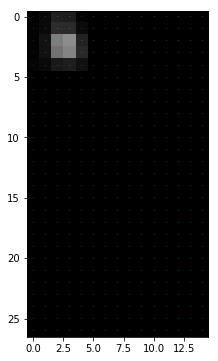

In [22]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = indices[0]
data = dfAll.Blobs.iloc[data_point]
print(dfAll.iloc[data_point])
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
# plt.savefig("input.png", bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

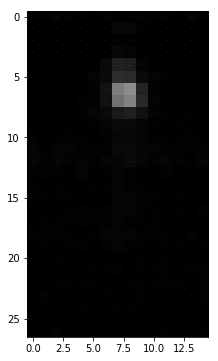

In [24]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = 11373
data = dfOG.loc[data_point].Image.reshape(27,15)
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
# plt.savefig("input.png", bbox_inches='tight')
plt.show()

In [ ]:
##### CREATE NEW IMAGES
imagelist = []
for data_point in indices:
    #print(data_point)
    #plt.subplot(figsize=(6,6))
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    data = df_test.Blobs.iloc[data_point]
    user = df_test.userID.iloc[data_point]
    task = df_test.TaskID.iloc[data_point]
    label = "Knuckle" if val_prediction[data_point][0] == 1 else "Finger"  
    ax.set_title("Input: " + str(df_test.InputMethod.iloc[data_point])  + " -Val: " + label + " -Task: " + str(df_test.TaskID.iloc[data_point]) + " -user: " +  str(df_test.userID.iloc[data_point]))
    ax.imshow(data[0:11, 0:9], cmap="gray", vmin=0, vmax=255)
    #fig.imsave("PredictionImages/{}.png".format(data_point))
    #plt.imsave("PredictionImages/" + str(data_point)+".pdf", data, cmap='gray', vmin=0, vmax=255)
    fig.savefig("PredictionImages/user%i_task%i_data%i.png" %(user, task, data_point) , bbox_inches = 'tight')
    fig.clf()

In [ ]:
imagelist = []
for data_point in indices:
    #print(data_point)
    #plt.subplot(figsize=(6,6))
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()
    data = df_train.Blobs.iloc[data_point]
    user = df_train.userID.iloc[data_point]
    task = df_train.TaskID.iloc[data_point]
    label = "Knuckle" if train_prediction[data_point][0] == 1 else "Finger"  
    ax.set_title("Input: " + str(df_train.InputMethod.iloc[data_point])  + " -Val: " + label + " -Task: " + str(df_train.TaskID.iloc[data_point]) + " -user: " +  str(df_train.userID.iloc[data_point]))
    ax.imshow(data[0:11, 0:9], cmap="gray", vmin=0, vmax=255)
    #fig.imsave("PredictionImages/{}.png".format(data_point))
    #plt.imsave("PredictionImages/" + str(data_point)+".pdf", data, cmap='gray', vmin=0, vmax=255)
    fig.savefig("PredictionImages/user%i_task%i_data%i.png" %(user, task, data_point) , bbox_inches = 'tight')
    fig.clf()


In [ ]:
imglist = []
filepath = "PredictionImages"
for file in os.listdir(filepath):
    if not file.endswith('.png'):
        continue   
    imglist.append(file)


In [ ]:
from fpdf import FPDF
for user in sorted(df_train.userID.unique()):
    pdf = FPDF()
    print("User: " + str(user))
    for task in sorted(df_test.TaskID.unique()):
        print("Task" + str(task))
        os.chdir("PredictionImages")
        x = 0
        y = 0
        
        pdf.add_page()
        for image in [i for i in imglist if "user"+str(user)+"_" in i and "task"+str(task)+"_" in i]:

            pdf.image(image,x,y,50,74)
            x = (x+50) %200
            if x == 0:
                y = (y+74) % 296
            if x == 0 and y == 0:
                pdf.add_page()
        os.chdir("..")
    pdf.output("PredictionPDFs/user%d.pdf" %(user), "F")

In [ ]:
from fpdf import FPDF
for user in sorted(df_test.userID.unique()):
    pdf = FPDF()
    print("User: " + str(user))
    for task in sorted(df_test.TaskID.unique()):
        print("Task" + str(task))
        os.chdir("PredictionImages")
        x = 0
        y = 0
        
        pdf.add_page()
        for image in [i for i in imglist if "user"+str(user)+"_" in i and "task"+str(task)+"_" in i]:

            pdf.image(image,x,y,50,74)
            x = (x+50) %200
            if x == 0:
                y = (y+74) % 296
            if x == 0 and y == 0:
                pdf.add_page()
        os.chdir("..")
    pdf.output("PredictionPDFs/user%d.pdf" %(user), "F")

In [ ]:
for user in sorted(df_train.userID.unique()):
    print("User: " + str(user))
    for task in sorted(df_test.TaskID.unique()):
        print("Task" + str(task))
        os.chdir("PredictionImages")
        x = 0
        y = 0
        
        pdf.add_page()
        for image in [i for i in imglist if "user"+str(user)+"_" in i and "task"+str(task)+"_" in i]:

            pdf.image(image,x,y,50,74)
            x = (x+50) %200
            if x == 0:
                y = (y+74) % 296
            if x == 0 and y == 0:
                pdf.add_page()
        os.chdir("..")
    pdf.output("PredictionPDFs/user%d.pdf" %(user), "F")